# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import modin.pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy import stats
# magic word for producing visualizations in notebook
from config import settings
from process_and_ml import load_azdias, load_customers, load_test_file
from process_and_ml import where_is
%matplotlib inline

# show all observation-related columns/rows
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
from process_and_ml.where_is import WhereIs

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.


In [2]:
where_is = WhereIs(False)


In [3]:
all_paths = where_is.get_paths_list


In [4]:
# Let's take a sample just to run much faster
sample_ratio = 1

In [ ]:
# Load in the general demographics data.
azdias = pd.read_csv(all_paths[0], sep=';').sample(frac=sample_ratio, random_state=settings.RANDOM_STATE)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()



In [8]:
azdias.head(20).T


,848815,299816,570748,354371,329018,49016,454415,361475,148484,363393,476938,835010,15886,704805,4547,440575,540600,715032,82107,197689
LNR,956771,536767,393990,596074,586471,502317,491540,975767,503118,616815,797567,523030,577062,972306,1001201,470462,852497,330372,267711,617593
AGER_TYP,1,-1,-1,-1,-1,1,-1,1,2,-1,1,-1,1,-1,-1,2,2,-1,-1,-1
AKT_DAT_KL,1.0,1.0,9.0,9.0,NaN,9.0,9.0,1.0,9.0,9.0,1.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0
ALTER_HH,12.0,0.0,0.0,16.0,NaN,10.0,0.0,11.0,4.0,0.0,0.0,14.0,18.0,21.0,19.0,8.0,0.0,17.0,16.0,0.0
ALTER_KIND1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOHNDAUER_2008,9.0,8.0,9.0,9.0,NaN,8.0,7.0,8.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,3.0,9.0
WOHNLAGE,4.0,3.0,7.0,3.0,NaN,3.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,4.0,3.0,4.0,3.0,7.0,5.0,5.0
ZABEOTYP,3.0,1.0,1.0,1.0,3.0,1.0,3.0,3.0,3.0,4.0,1.0,2.0,3.0,4.0,1.0,3.0,3.0,1.0,6.0,3.0
ANREDE_KZ,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0


In [ ]:
azdias.info()


In [ ]:
azdias.describe()

In [ ]:
azdias.shape

In [7]:
#number of missing values by each column in azdias dataset
col_nul_percent=azdias.isnull().sum()/azdias.shape[0]

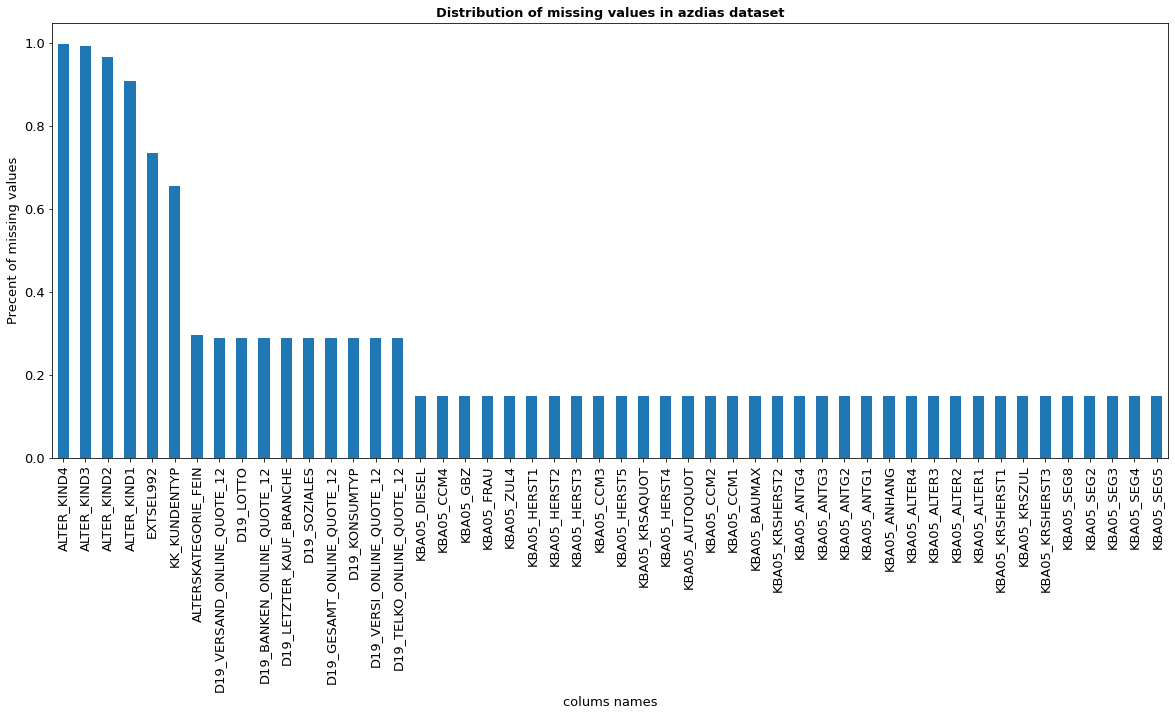

In [8]:

plt.title("Distribution of missing values in azdias dataset",fontsize=13,fontweight="bold")
plt.xlabel("colums names",fontsize=13)
plt.ylabel("Precent of missing values",fontsize=13)
(col_nul_percent.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13));

In [9]:
#Distribution of missing values by columns:-
missing_by_col=azdias.isnull().sum()/azdias.shape[0]

Text(0, 0.5, 'count')

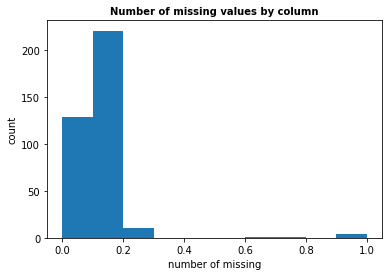

In [10]:
plt.hist(missing_by_col)
plt.title("Number of missing values by column",fontsize=10,fontweight="bold")
plt.xlabel("number of missing",fontsize=10)
plt.ylabel("count",fontsize=10)



### We have another 2 dataframe with information let's check them



In [ ]:
# First the info data frame
df_info = pd.read_excel(all_paths[23])

In [25]:
df_info.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Information level,Attribute,Description,Additional notes
1,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
2,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
3,NaN,NaN,ANREDE_KZ,gender,NaN
4,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."


In [24]:
df_info.shape
"""Creates `features` and `labels` splits and fill NA values
    for categorical features passed in `cat_features` from data
    in `df` dataframe

    Target feature must be provided in `target` arg

    `test_size` and `valid_size` has to be greater than zero and
    less too one, if it is 0 removes that split set
    """

(314, 5)

### We have some columns with information, but some columns is missing


In [ ]:
## Let's check the the attributes dataframe


In [26]:
df_info = pd.read_excel(all_paths[22])


In [27]:
df_info.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Attribute,Description,Value,Meaning
1,NaN,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,NaN,0,no classification possible
3,NaN,NaN,NaN,1,passive elderly
4,NaN,NaN,NaN,2,cultural elderly


In [29]:
df_info.shape

(2259, 5)

# Well on this dataframe we have some information about invalid values, let's use it to set as NaN values

#### Before start to clean up data let's try to find the feature importance using Catboost algorithm,
#### For that we ll use another notebook catboost_try.ipynb, if we do here, ll be a mess.

### Now we created file with info from an attribute dataframe, that file ll help us to set unknown data as Nan

## We ll remove all columns are not in both information and attributes datasets, and also choose a Nan threshold
### Let's create a wrangler file to help us

## Time to use the DvC to make versioning of dataframes
